In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob


# hand made functions
from Rouss1 import *
from Rouss2 import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "first_2D"
exe_name="../../exe/mf6"

In [3]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../data/MNT/MNT_50.tif"
MNT20_path = "../../data/MNT/MNT_20.tif"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

In [4]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 += 1000

Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = nrow = 250
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)

idomain = np.zeros((nrow*ncol))

In [5]:
# load top data
MNT = Raster.load(MNT_path)
#MNT20 = Raster.load(MNT20_path)

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                 # to pre-process data

top = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [6]:
# load botom based on the differents surfaces
folder_path = "../../data/txt_couches_nouv"
surfaces = []
for file in glob.glob(os.path.join(folder_path, '*.txt')):
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
BOT = PMS.copy()
BOT[PMS==-9999] = PC[PMS==-9999]
BOT[PC==-9999] = Q[PC==-9999]
BOT[BOT==-9999] = top[BOT==-9999] - 50

BOT[(top-BOT)<=10] = top[(top-BOT)<=10] - 10 # minimum of 10 m thickness to avoid bug and numerical issues

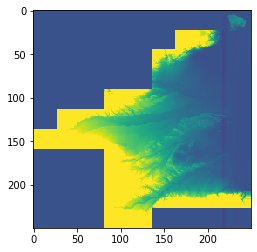

In [7]:
a=plt.imshow(top-BOT[0])
a.set_clim(0,200)

In [8]:
# Define the domain

R = gp.read_file(R_path) # import shapefile with geopandas

# cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0) # all the cells of the model

In [9]:
# recharge areas
path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(path,grid)

In [10]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [11]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [12]:
# BC Agly
Agy_chd = Complete_riv(Agly_path,"../../data/Fleuves/stations_agly.csv",us=28,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
# BC Tet
Tet_chd = Complete_riv(Tet_path,"../../data/Fleuves/stations_tet2.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [14]:
#BC Boul
Bol_chd = Complete_riv(Bol_path,"../../data/Fleuves/stations_bol.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [15]:
## BC Reart
Rea_chd = Complete_riv(Rea_path,"../../data/Fleuves/stations_reart.csv",us=130,ds=0,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [16]:
## BC Cant
Cant_chd = Complete_riv(Cant_path,"../../data/Fleuves/stations_cant.csv",us=135,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [17]:
# BC Tech
Tech_chd = Complete_riv(Tech_path,"../../data/Fleuves/stations_tech.csv",us=170,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [18]:
# drains everywhere...
# drains are applied at each cells 1 meter below the top in order to take into account superficial runoff and little rivers

drn_areas=inter_lst(lst_domain,lst_chd,typ="unique")
lst_drn=[]
for cellid in drn_areas:
    i = cellid[0]
    j = cellid[1]
    k = cellid[2]
    
    xc = grid.xcellcenters[j,k]
    yc = grid.ycellcenters[j,k]
    
    lst_drn.append(((i,j,k),top[j,k]-1,0.01))

In [19]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"
V_col = "V_A_AEMRC"
layer = 0
stress_data_well = importWells(path,grid,lst_domain,V_col=V_col,layer=layer)

In [20]:
# permeability

# initialize arrays that will define the position of the formations
idomainQ_rec = np.zeros([nrow*ncol])
idomainQ_a = np.zeros([nrow*ncol])
idomainPlio = np.zeros([nrow*ncol])

pathQr = "../../data/shp/entités/Alluv_rec.shp" # shapefile of the Quaternary formations
pathQa = "../../data/shp/entités/Alluv_anc.shp" #...
pathP = "../../data/shp/entités/Pliocene.shp"
lstIDQ_rec = gp2idomain(gp.read_file(pathQr),grid,idomainQ_rec,area=10) #create the domains of each shp
lstIDQ_anc = gp2idomain(gp.read_file(pathQa),grid,idomainQ_a,area=10) 
lstIDQPlio = gp2idomain(gp.read_file(pathP),grid,idomainPlio,area=10)


In [21]:
# define k, different for each lithology
kh = 1e-4 # general k
kQr = 4e-5 # k for recent Quaternary
kQa = 2.6e-5 # k for ancient Quaternary
kp = 1e-5 # k for pliocene

k = np.ones([nrow*ncol])*kh # vector containing the permeability array(layer,nrow,ncol)
k[idomainPlio==1] = kp
k[idomainQ_rec==1] = kQr
k[idomainQ_a==1] = kQa

In [22]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="1990",np_col="NP_corr",x_col="x",y_col="y")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [23]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='moderate')


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k, save_flows=True,save_specific_discharge=True)


# recharge
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
   
    
# well package
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="wel.wel",
                           stress_period_data=stress_data_well, maxbound=len(stress_data_well))

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

drn = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname='drn', maxbound=len(lst_drn), 
                                               stress_period_data={0: lst_drn}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [24]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package wel...
    writing package sea...
    writing package eta...
    writing package drn...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although 

(True, [])

In [25]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

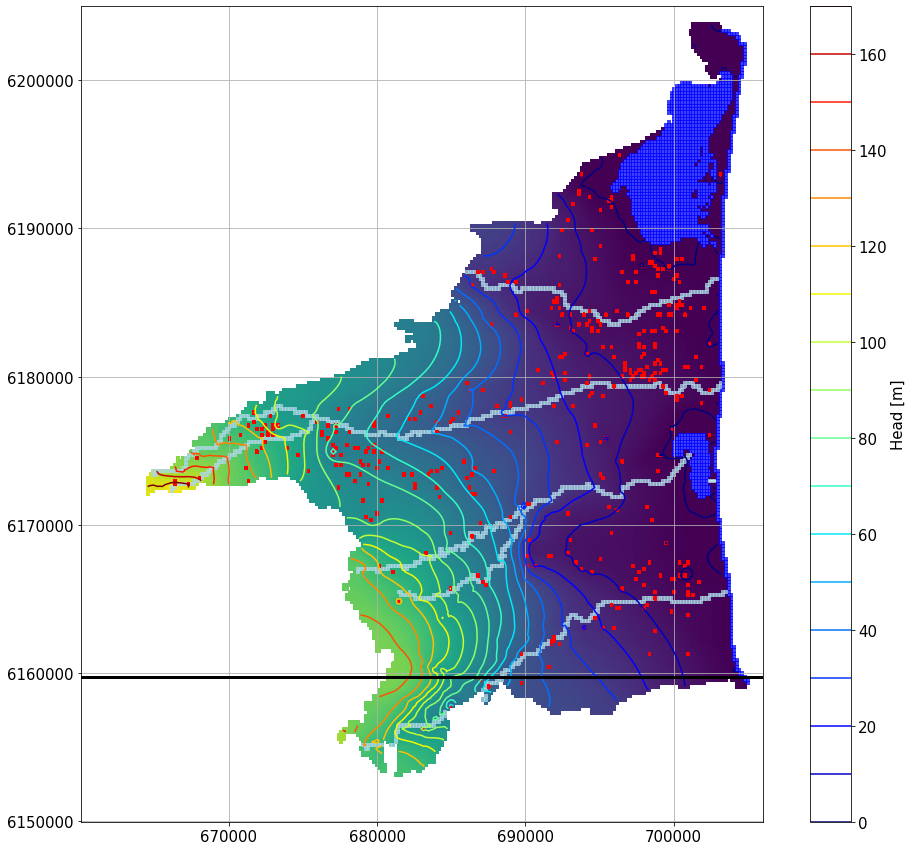

In [26]:
# make a plot
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.plot_array(head,masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,180)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)
ml.plot_bc("wel") # plot the wells  

# plot Cross-section
row = 205
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

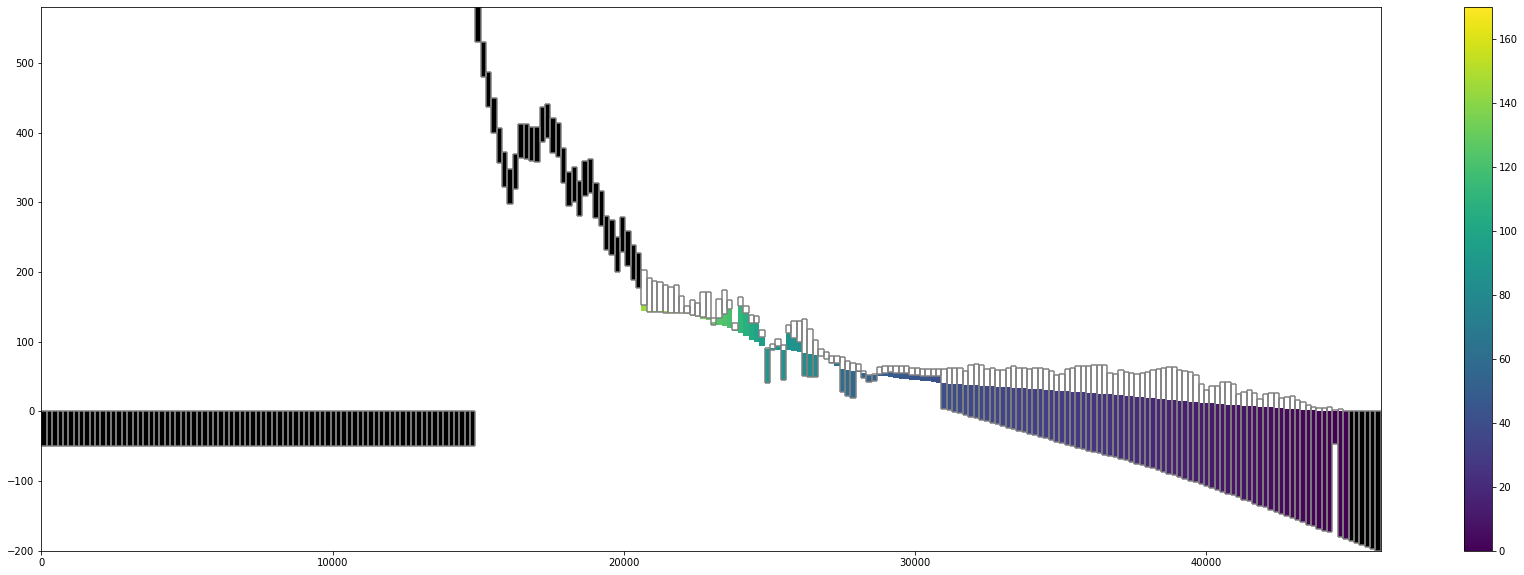

In [27]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()

In [28]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

In [29]:
for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

WEL_IN : 0.0 m3/s
DRN_IN : 0.0 m3/s
RCH_IN : 2.9024999141693115 m3/s
CHD_IN : 0.5185999870300293 m3/s
TOTAL_IN : 5.61929988861084 m3/s
WEL_OUT : 1.503100037574768 m3/s
DRN_OUT : 2.37280011177063 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 0.04652100056409836 m3/s
TOTAL_OUT : 5.61959981918335 m3/s
IN-OUT : -0.00036735000321641564 m3/s


Text(0.5, 1.0, 'fit measured vs simulated')

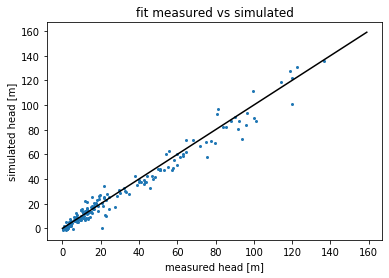

In [30]:
head[head>1000]=0
plt.scatter(Control_pz[Control_pz!=0],
            head[0][Control_pz!=0],s=4)
plt.plot(np.arange(160),np.arange(160),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")

In [31]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit : 3.6467443783104074 m 


In [32]:
Misfit2 = (np.sum((((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)/Control_pz[Control_pz!=0].shape[0])))**0.5
print("RMSE : {}".format(Misfit2))

RMSE : 5.304121422781216
